In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from dotenv import load_dotenv

In [2]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
hop_length = int(os.getenv('hop_length'))
n_mels = int(os.getenv('n_mels'))
n_fft = int(os.getenv('n_fft'))
mse_threshold = float(os.getenv('mse_threshold'))

In [3]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            target_sample_rate = sr
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [4]:
segmented_files_anomaly = load_segmented_files('output_anomaly')
# 打亂 segmented_files_anomaly 列表
np.random.shuffle(segmented_files_anomaly)

100%|██████████| 45/45 [00:00<00:00, 305.12it/s]


In [5]:
print(segmented_files_anomaly[0])

(array([0.16256714, 0.16238403, 0.16229248, ..., 0.05258179, 0.05249023,
       0.05267334], dtype=float32), 'anomaly-0616-02-24_02-24-13_segment_1.wav')


In [6]:
def convert_to_mel_spectrogram(audio, sr, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [7]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, mse_threshold, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    mse = np.square(input_mel_spectrogram - output_mel_spectrogram).mean()
    # plot mse if mse in red if mse > mse_threshold
    plt.text(0, 0, f'MSE: {mse}', fontsize=12, color='red' if mse > mse_threshold else 'black', backgroundcolor='white')
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

In [8]:
mel_spectrograms_anomaly_array = [convert_to_mel_spectrogram(audio[0], sample_rate, n_fft, hop_length, n_mels) for audio in
                           tqdm(segmented_files_anomaly)]
# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_anomaly_array = np.array(mel_spectrograms_anomaly_array)
# 調整數據的形狀
mel_spectrograms_anomaly_array = mel_spectrograms_anomaly_array.reshape(mel_spectrograms_anomaly_array.shape[0],
                                                                        mel_spectrograms_anomaly_array.shape[1],
                                                                        mel_spectrograms_anomaly_array.shape[2], 1)

# 數據歸一化到 [0, 1]
mel_spectrograms_anomaly_array = (mel_spectrograms_anomaly_array - mel_spectrograms_anomaly_array.min()) / (
            mel_spectrograms_anomaly_array.max() - mel_spectrograms_anomaly_array.min())

print(mel_spectrograms_anomaly_array.shape)

100%|██████████| 45/45 [00:00<00:00, 120.34it/s]

(45, 64, 1034, 1)


# Load the trained autoencoder model

In [9]:
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder.h5')

In [10]:
# 檢查模型結構
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1034, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 1034, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 517, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 517, 16)       4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 259, 16)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 259, 8)        1160  

In [11]:
# 驗證異常數據
mel_spectrograms_anomaly_array_reconstructed = autoencoder.predict(mel_spectrograms_anomaly_array)
print(mel_spectrograms_anomaly_array.shape, mel_spectrograms_anomaly_array_reconstructed.shape)

2/2 [==============================] - 9s 140ms/step
(45, 64, 1034, 1) (45, 64, 1034, 1)


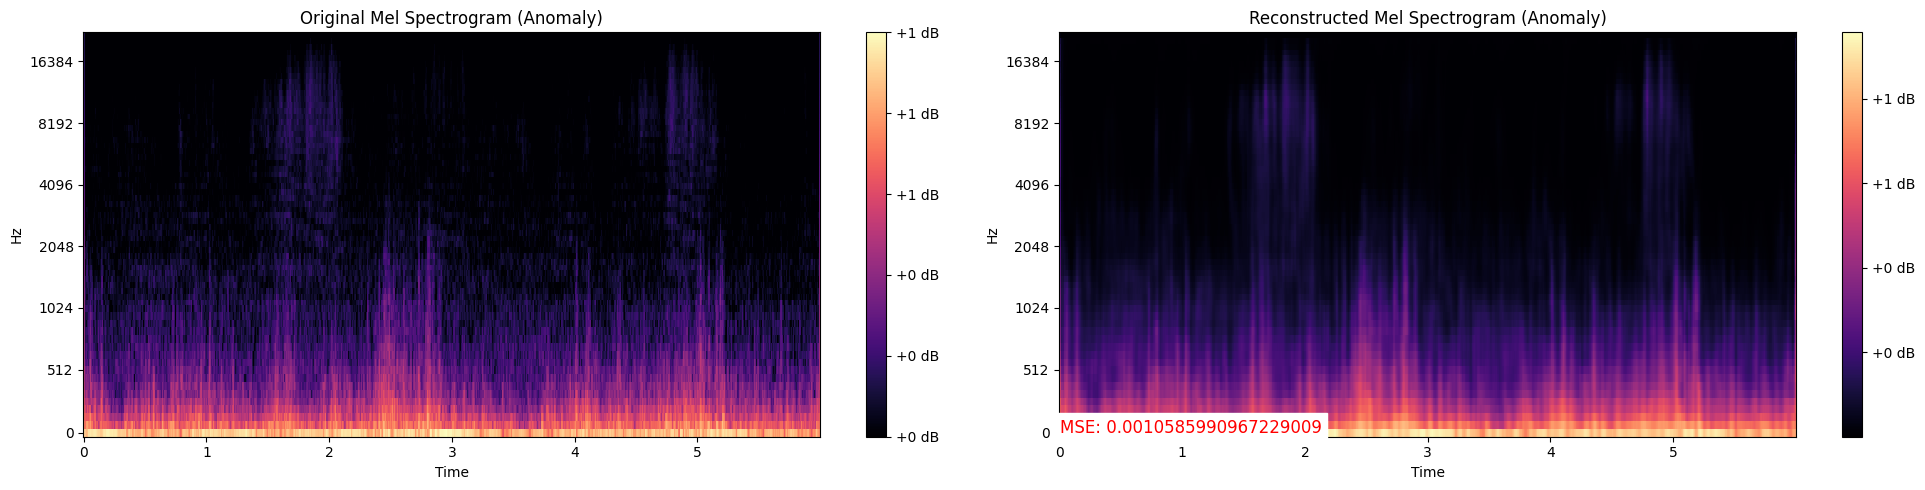

In [12]:
anomaly_index = 5
plot_comparison(
    mel_spectrograms_anomaly_array[anomaly_index].reshape(mel_spectrograms_anomaly_array[anomaly_index].shape[0],
                                                          mel_spectrograms_anomaly_array[anomaly_index].shape[1]),
    mel_spectrograms_anomaly_array_reconstructed[anomaly_index].reshape(
        mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[0],
        mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[1]), mse_threshold=mse_threshold,
    input_title='Original Mel Spectrogram (Anomaly)', output_title='Reconstructed Mel Spectrogram (Anomaly)')

In [21]:
for i in tqdm(range(0, len(mel_spectrograms_anomaly_array))):
    plot_comparison(
        mel_spectrograms_anomaly_array[i].reshape(mel_spectrograms_anomaly_array[i].shape[0],
                                                  mel_spectrograms_anomaly_array[i].shape[1]),
        mel_spectrograms_anomaly_array_reconstructed[i].reshape(
            mel_spectrograms_anomaly_array_reconstructed[i].shape[0],
            mel_spectrograms_anomaly_array_reconstructed[i].shape[1]),
        'Original Mel Spectrogram (Anomaly)', 'Reconstructed Mel Spectrogram (Anomaly)' , output_name=f'images/reconstruct_anomaly/{segmented_files_anomaly[i][1]}', mse_threshold=mse_threshold, save_only=True)

100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


100%|██████████| 45/45 [00:00<00:00, 11248.80it/s]

anomaly-0616-02-24_02-24-13_segment_1.wav: 0.0012268261052668095
anomaly-0616-02-24_02-24-15_segment_0.wav: 0.0008824454853311181
anomaly-0616-02-24_02-24-10_segment_0.wav: 0.0009247227571904659
anomaly-0616-02-24_02-24-20_segment_1.wav: 0.0010585990967229009
anomaly-0616-02-24_02-24-11_segment_1.wav: 0.0010182206751778722
anomaly-0616-02-24_02-24-17_segment_0.wav: 0.0009864935418590903
anomaly-0616-02-24_02-24-06_segment_1.wav: 0.0011228157673031092
anomaly-0616-02-24_02-24-14_segment_0.wav: 0.0009054365800693631
anomaly-0616-02-24_02-24-05_segment_1.wav: 0.0011687607038766146
anomaly-0616-02-24_02-24-07_segment_1.wav: 0.001139913802035153
anomaly-0616-02-24_02-24-04_segment_0.wav: 0.0009251344599761069
anomaly-0616-02-24_02-24-12_segment_1.wav: 0.0010368556249886751
anomaly-0616-02-24_02-24-16_segment_1.wav: 0.0011472385376691818
anomaly-0616-02-24_02-24-02_segment_1.wav: 0.0011565168388187885
anomaly-0616-02-24_02-24-13_segment_0.wav: 0.0009198147454299033
anomaly-0616-02-24_02-24-1

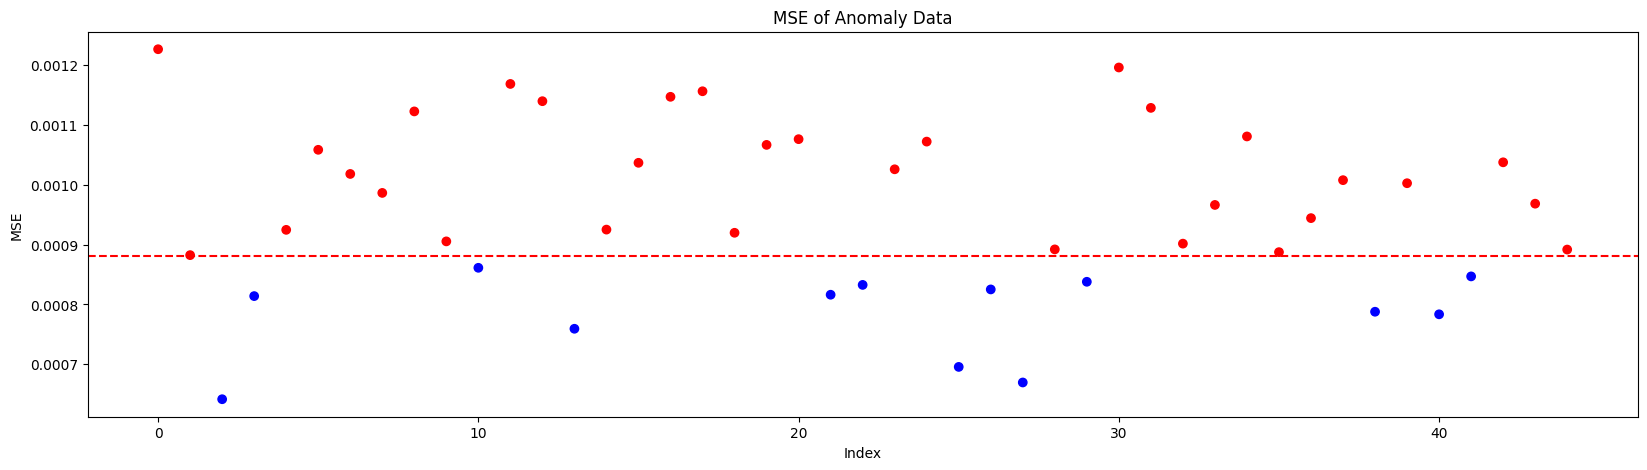

In [37]:
mse_list = []
mse_threshold = 0.00088033621
for i in tqdm(range(0, len(mel_spectrograms_anomaly_array))):
    mse = np.square(mel_spectrograms_anomaly_array[i] - mel_spectrograms_anomaly_array_reconstructed[i]).mean()
    if mse > mse_threshold:
        print(f'{segmented_files_anomaly[i][1]}: {mse}')
    mse_list.append(mse)

# plot mse scatter plot
plt.figure(figsize=(20, 5))
# use red color if mse > mse_threshold
plt.scatter(range(0, len(mse_list)), mse_list, color=['red' if mse > mse_threshold else 'blue' for mse in mse_list])
plt.axhline(y=mse_threshold, color='r', linestyle='--')
plt.title('MSE of Anomaly Data')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.savefig('images/mse_anomaly.png')
print('Accuracy:', len([mse for mse in mse_list if mse > mse_threshold]) / len(mse_list) * 100, '%')
